# Chat API

user와 assistant의 역할을 지정, 각각의 content를 순서대로 저장해 문맥을 이해하고 대화에 맞는 문장을 제공하는 API

API를 이용할 때 아래 두 요소는 필수적으로 요구된다.

- model: 사용할 모델. 'gpt-3.5-turbo', 'gpt-4' 등이 있다.
    - 'gpt-4'는 현재 요금제를 이용하는 개발자에 한해 제공된다. (23년 7월)

- messages: message object(dictionary)를 원소로 하는 리스트. 각 원소는 아래의 필드(key)를 가진다.
    - role: 메시지의 주체. system, user, assistant가 있다.
    - content: 메시지 내용.

In [1]:
import openai

f = open('../api_key.txt')
api_key = f.read()

openai.api_key = api_key

In [4]:
messages = [{'role': 'user', 'content': '안녕하세요'}]
completion = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=messages,
)

completion
'''
API response
json type의 데이터
하단의 response를 확인해 구조를 알 수 있다.
'''

<OpenAIObject chat.completion id=chatcmpl-7gLuUgzTZEnZtY99D3S0dXZkG7MhJ at 0x240ff303e90> JSON: {
  "id": "chatcmpl-7gLuUgzTZEnZtY99D3S0dXZkG7MhJ",
  "object": "chat.completion",
  "created": 1690328354,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "\uc548\ub155\ud558\uc138\uc694! \ub300\ud654\ud560 \uac83\uc774 \uc788\ub098\uc694?"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 12,
    "completion_tokens": 15,
    "total_tokens": 27
  }
}

- id: API request의 id
- object: response 받은 object의 type
- created: request의 timestamp
- model: request에 사용한 model의 이름
- choices: completion을 담은 리스트
    - index: choices 안 completion의 index
    - message: model이 만들어낸 object(role과 content를 가짐)
    - finish_reason: completion 생성 종료의 이유(일반적으로 stop, max_tokens 제한에 걸리면 length를 가짐)
- usage: prompt, completion의 토큰, 토큰의 총합

In [2]:
messages = [] # 대화를 저장할 리스트. role과 content를 key로 가지는 dictionary를 원소로 가진다.

In [4]:
while True:
    content = input('user: ')
    if content in 'stop quit x X 종료 정지 그만'.split(): # API를 종료할 단어
        print('대화를 종료합니다.')
        break
    print()
    
    messages.append({'role': 'user', 'content': content})
    
    completion = openai.ChatCompletion.create(
        model='gpt-4',
        messages=messages
    )
    
    chat_response = completion.choices[0].message.content
    print('ChatAPI:\n', chat_response, '\n')
    
    messages.append({'role':'assistant', 'content':chat_response})


ChatAPI:
 저도 만나서 반갑습니다! 어떤 정보를 찾고 계신가요? 


ChatAPI:
 1. "조금 밝게 해줄 수 있을까요? 방이 좀 어두운 것 같아요."
2. "어두워서 잘 보이지 않아, 불 좀 켜 줄래?"
3. "방안이 어두워서 무엇인지 확인이 잘 안돼. 조명을 해줄 수 있을까요?"
4. "혹시, 방에 불을 좀 밝혀줄 수 있나요?"
5. "여기가 꽤 어두워진 것 같은데, 불 좀 켜줄 수 있을까요?"
6. "방이 어두워서 물건들이 제대로 보이지 않아. 불을 좀 켜주시겠어요?"
7. "방안이 좀 어두운 것 같아. 조명을 켜주면 좋겠어."
8. "어둠 속에서는 무언가를 찾기 힘들어. 빛을 좀 켜줄 수 있을까?"
9. "여긴 왠지 어두워서 불편한 것 같아. 불 좀 켜 줘."
10. "방안이 공포 영화 속 같아서 무섭네. 불 좀 켜줘." 

대화를 종료합니다.


### system role 활용법
첫 request를 보낼 때 role에 system, content에 지시사항을 기록하면 해당 지침에 따라 response를 준다.

instruction으로 상세한 설명을 요구하니 이전의 예시와 다르게 아래의 예시는 질문에 대한 대답 이외의 것도 추가 설명해주는 것을 볼 수 있음

*잘못된 설명 포함됨

In [27]:
Rmessages = [
    {'role':'system', 'content':'간단한 질문에도 상세한 설명을 해야 한다.'},
    {'role':'user', 'content':'2018년 올림픽이 어디서 개최됐어?'}
]
completion = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=messages
)

print(completion.choices[0].message.content)

2018년 동계 올림픽은 대한민국의 평창에서 개최되었습니다. 평창은 강원도에 위치한 도시로서, 팔레트 산맥의 일부인 평창알프스 지역에서 경기가 열렸습니다. 동계 올림픽은 16개 종목의 스포츠가 개최되었고, 여러 나라의 선수들이 참가하여 겨울 스포츠의 경기를 펼쳤습니다.


### Few-shot prompting

model에게 원하는 내용의 completion을 설명하기보다 직접 completion을 작성해 few-shot learning을 진행하면 더 좋은 결과를 얻을 수 있다.

model이 실제 생성된 대화가 아니며 직접 작성한 content를 다시 언급하지 않도록 name 필드를 추가해 구분지어주는 것이 좋다. (example_user, example_assistant로 구분할 수 있음)

In [36]:
messages = [
    {'role':'system', 'content':'한국 속담을 해석해 쉬운 단어로 풀이해야 한다.'},
    {'role':'system', 'name':'example_user', 'content':'까마귀 날자 배 떨어진다.'},
    {'role':'system', 'name':'example_assistant', 'content':'아무 관계없이 한 일이 우연히 다른 일과 때가 같아, 둘 사이에 무슨 관계라도 있는 것처럼 의심을 받게 된다는 의미입니다.'},
    {'role':'system', 'name':'example_user', 'content':'바늘 가는 데 실 간다.'},
    {'role':'system','name':'example_assistant', 'content':'바늘 뒤를 실이 꼭 따라가야 바느질이 되듯이 꼭 붙어있는 친밀한 관계를 의미하는 속담입니다.'},
    {'role':'system','name':'example_user', 'content':'굼벵이도 구르는 재주가 있다.'},
    {'role':'system','name':'example_assistant', 'content':'아무리 능력이 없는 사람이라도 한 가지 재주는 있다는 뜻입니다.'},
    {'role':'user', 'content':'바늘 도둑 소 도둑 된다.'}
]

completion = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=messages
)
print(completion.choices[0].message.content)

다른 사람의 작은 물건을 훔치는 사람은 어느쪽으로든 범죄자로 변할 수 있다는 의미입니다.


In [37]:
messages = [
    {'role':'system', 'content':'철자 오류가 있는 문장을 올바르게 고쳐야 한다.'},
    {'role':'system', 'name':'example_user', 'content':'콩기질 알려줘.'},
    {'role':'system', 'name':'example_assistant', 'content':'공기질 알려줘.'},
    {'role':'system', 'name':'example_user', 'content':'권기질 알려줘.'},
    {'role':'system', 'name':'example_assistant', 'content':'공기질 알려줘.'},
    # {'role':'system', 'name':'example_user', 'content':'옹기질 알려줘.'},
    # {'role':'system', 'name':'example_assistant', 'content':'공기질 알려줘.'},
    # {'role':'system', 'name':'example_user', 'content':'온기질 알려줘.'},
    # {'role':'system', 'name':'example_assistant', 'content':'공기질 알려줘.'},
    
    {'role':'user', 'content':'겅기질 알려져.'}
]

completion = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=messages,
    temperature=0
)
print(completion.choices[0].message.content)

공기질 알려줘.


<hr/>

# Completions API

prompt를 제공하면 그에 따른 답변을 제공하는 API

Chat API와 달리 이전의 내용을 기억하지 못한다.

API를 사용할 때 아래 두 요소는 필수적으로 요구된다.

- model: completion을 생성할 모델
- prompt: model에 전달할 prompt

In [3]:
import openai

f = open('../api_key.txt')
api_key = f.read()

openai.api_key = api_key

In [4]:
prompt = ['저녁 메뉴 한식 중에서 추천해줘', '태풍 대비 방법 알려줘']

completion = openai.Completion.create(
    model='text-davinci-003',
    prompt = prompt,
    max_tokens = 100,
)

for com in completion.choices:
    print(com['text'])



김치찌개가 좋아요! 김치찌개에 들어가는 재료는 보통 매콤한 고추장, 된장, 대


1. 태풍 대비를 위해 가장 우선적으로 해야 할 일은 관련 정보를 확인하는 것입니다.


In [5]:
completion

<OpenAIObject text_completion id=cmpl-7mDj4eNbJUXup03go20pYVLulXlIg at 0x27dffe8d810> JSON: {
  "warning": "This model version is deprecated. Migrate before January 4, 2024 to avoid disruption of service. Learn more https://platform.openai.com/docs/deprecations",
  "id": "cmpl-7mDj4eNbJUXup03go20pYVLulXlIg",
  "object": "text_completion",
  "created": 1691726862,
  "model": "text-davinci-003",
  "choices": [
    {
      "text": "\n\n\uae40\uce58\ucc0c\uac1c\uac00 \uc88b\uc544\uc694! \uae40\uce58\ucc0c\uac1c\uc5d0 \ub4e4\uc5b4\uac00\ub294 \uc7ac\ub8cc\ub294 \ubcf4\ud1b5 \ub9e4\ucf64\ud55c \uace0\ucd94\uc7a5, \ub41c\uc7a5, \ub300",
      "index": 0,
      "logprobs": null,
      "finish_reason": "length"
    },
    {
      "text": "\n\n1. \ud0dc\ud48d \ub300\ube44\ub97c \uc704\ud574 \uac00\uc7a5 \uc6b0\uc120\uc801\uc73c\ub85c \ud574\uc57c \ud560 \uc77c\uc740 \uad00\ub828 \uc815\ubcf4\ub97c \ud655\uc778\ud558\ub294 \uac83\uc785\ub2c8\ub2e4.",
      "index": 1,
      "logprobs": null,
    

Chat API를 사용할 때와 비슷한 형식의 response를 받는다.

- id: API request의 id
- object: response 받은 object의 type
- created: request의 timestamp
- model: request에 사용한 model의 이름
- choices: completion을 담은 리스트
    - text: model이 만들어낸 텍스트
    - index: choices 안 completion의 index
    - logprobs: log probability를 보여줌. 토큰마다 가장 비슷한 토큰을 보여줌
    - message: model이 만들어낸 object(role과 content를 가짐)
    - finish_reason: completion 생성 종료의 이유(일반적으로 stop, max_tokens 제한에 걸리면 length를 가짐)
- usage: prompt, completion의 토큰, 토큰의 총합

<hr/>

# Edits API

특정 지시사항에 맞춰 prompt를 변경해주는 API (deprecated)

API를 사용할 때 아래의 세 요소를 필수로 요구한다.

- model: Edits을 실행할 model
- input: API가 수정할 prompt
- instruction: API가 수행할 지시사항

In [1]:
import openai

f = open('../api_key.txt')
api_key = f.read()

openai.api_key = api_key

In [2]:
completion = openai.Edit.create(
    model='text-davinci-edit-001',
    input='원기질 알려줘',
    instruction='맞춤법 수정해줘'
)
completion.choices[0].text

'원기질 알려줘\n\n다시도록 맞춤법 수정해줘\n'

In [5]:
type(completion)

openai.openai_object.OpenAIObject

response의 데이터는 이전 Chat, Completions의 데이터 유형과 유사하다.

<hr/>

# Images API

이미지를 생성, 수정, 다양화하는 데에 쓰이는 API

#### Create Image

    원하는 이미지를 만들어낸다.
    
    
#### Create Image edit
    
    이미지를 입력하는 prompt에 맞춰 수정해준다.
    mask를 설정할 수 있다.
    
    
#### Create Image variation

    제공하는 이미지를 다양하게 변경해준다.
    
    
    
model을 따로 설정하지 않음

images에 적용되는 모델은 고정되어 보임

In [6]:
import openai

f = open('../api_key.txt')
api_key = f.read()

openai.api_key = api_key

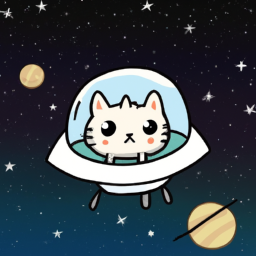

In [10]:
import requests
from io import BytesIO
from PIL import Image

created_img = openai.Image.create(
  prompt="A cute cat floating in the space",
  n=1,
  size="256x256"
)

url = created_img.data[0].url
res = requests.get(url)
img = Image.open(BytesIO(res.content))
img

In [11]:
created_img

<OpenAIObject at 0x27d88039770> JSON: {
  "created": 1691728172,
  "data": [
    {
      "url": "https://oaidalleapiprodscus.blob.core.windows.net/private/org-A3gPHGdr7XUndMOogFLns21U/user-SczKK6v1JkEeKSPEHoxKVH5h/img-D0cVjXCdB95jNOcYIaJUOmnO.png?st=2023-08-11T03%3A29%3A32Z&se=2023-08-11T05%3A29%3A32Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2023-08-10T20%3A56%3A55Z&ske=2023-08-11T20%3A56%3A55Z&sks=b&skv=2021-08-06&sig=Uxo9I0OmOS/rLXpOjzM5DL2wGTxfW3PZInDbjipoYII%3D"
    }
  ]
}

In [12]:
created_img = openai.Image.create(
  prompt="A cute cat floating in the space",
  n=1,
  size="256x256",
  response_format='b64_json'
)
created_img

<OpenAIObject at 0x27de033cf90> JSON: {
  "created": 1691731358,
  "data": [
    {
      "b64_json": "iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAIAAADTED8xAAAAaGVYSWZNTQAqAAAACAACknwAAgAAACkAAAAmkoYAAgAAABgAAABQAAAAAE9wZW5BSS0tYWFkOWViNDRmMGM4NjMwZjQzYTVjODA1NDI5OTRhZmEAAE1hZGUgd2l0aCBPcGVuQUkgREFMTC1FAO4+87kAAQAASURBVHgBACuB1H4BAAAAAAAAAAAAAQAA/wAAAAABAAD/AQAAAAEBAAAA/wAAAf8AAAEAAAAAAAABAAIAAQEBIhEhpIWfHBQWBQICBAEEAQAAAAAA////AAABAAAAAAAAAQAAAQEA/gD+6/vvVHJc2OXc/v/+/v//AQD/AAABAAD/AP8BAAH///8AAAABAQD//wAAAAAAAAEAAQABAAAAAAAAAP8AAAAA/wAAAQD//wEAAP8AAAAAAAAAAAAAAAAAAQAA/wAAAQAB/wAAAAH/AP8BAQH/AP8B/wD/AAEAAP8BAAD/AAEBAAAAAP//AAAAAQAA/wAAAAAAAAAAAQAAAAAAAAAB/wAAAQD/AAAA/wEAAP8AAQEBAAD///8AAAAAAQAA/wEAAAABAP8AAAD/AQAAAAAB/wAAAQEA//8BAAD/AQAAAAAAAAEAAP///wABAQEA////AQEA/wABAf8A/wD/AAEAAP8AAQAB/wH/AP8AAAABAAD/AAAAAAABAAEAAP//AAAAAAABAQH//wABAP//AAEBAP8AAQAAAAH//wABAP//AAAAAAAAAQAA/wABAQEAAAD/AP8AAAEBAAAAAAAAAAAAAAAAAAAAAP//AAABAAEAAP8AAAEAAP8AAAAAAAH/AP8B/wD/AAAAAQEB////AAAAAQABAAH///8AAAABAAEAAAD/Af

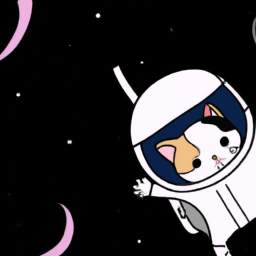

In [13]:
img = Image.open(BytesIO(base64.b64decode(created_img['data'][0]['b64_json'])))
img

In [90]:
img = img.convert('RGBA')
img.save('./image/cat.png', 'png')

In [15]:
mask_img = Image.open('../data/image/mask.png')
resized_mask = mask_img.resize((256,256))
resized_mask.save('../data/image/resized_mask.png')

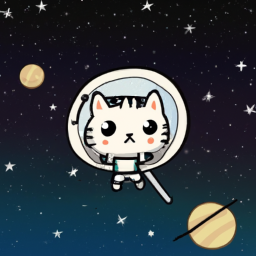

In [18]:
edited_img = openai.Image.create_edit(
    image=open('../data/image/cat.png', 'rb'),
    prompt='erase the spaceship and draw the spacesuit',
    n=1,
    size='256x256',
    mask=open('../data/image/resized_mask.png', 'rb')
)

edit_url = edited_img.data[0].url
res = requests.get(edit_url)
img = Image.open(BytesIO(res.content))
img

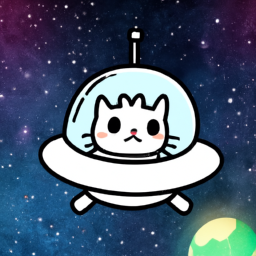

In [19]:
img_variations = openai.Image.create_variation(
    image=open('../data/image/cat.png', 'rb'),
    n=1,
    size='256x256'
)

variation_url = img_variations.data[0].url
res = requests.get(variation_url)
img = Image.open(BytesIO(res.content))
img


<hr/>

# Audio API

음성 파일을 읽어 transcription(STT), translation(번역) 기능을 제공하는 API

whisper 모델을 사용하며 25MB 이하의 mp3, mp4, mpeg, mpga, m4a, wav, webm 파일을 읽을 수 있다.

API를 사용할 때 아래 두 요소는 필수적으로 요구된다.

 - model : audio 파일을 읽을 모델
 - file : 작업할 audio 파일




### transcription

파일을 읽어 음성을 문자로 변환하는 기능을 제공

In [30]:
import openai
f = open('../api_key.txt')
api_key = f.read()
openai.api_key = api_key

In [41]:
audio_file = open('../data/audio/audio.mp3', 'rb')
transcription = openai.Audio.transcribe(
    model='whisper-1',
    file=audio_file,
    response_format='json'
)

transcription['text']

'나래야, 문 열어줘. 문 열어줄래? 문 열어.'

In [34]:
audio_file = open('../data/audio/audio.mp3', 'rb')
transcription = openai.Audio.transcribe(
    model='whisper-1',
    file=audio_file,
    response_format='text'
)

transcription

'나래야, 문 열어줘. 문 열어줄래? 문 열어.\n'

In [35]:
audio_file = open('../data/audio/audio.mp3', 'rb')
transcription = openai.Audio.transcribe(
    model='whisper-1',
    file=audio_file,
    response_format='srt'
)

transcription

'1\n00:00:00,000 --> 00:00:08,000\n나래야, 문 열어줘. 문 열어줄래? 문 열어.\n\n\n'

In [36]:
audio_file = open('../data/audio/audio.mp3', 'rb')
transcription = openai.Audio.transcribe(
    model='whisper-1',
    file=audio_file,
    response_format='verbose_json'
)

transcription

<OpenAIObject at 0x27d88c9f4f0> JSON: {
  "task": "transcribe",
  "language": "korean",
  "duration": 8.07,
  "text": "\ub098\ub798\uc57c, \ubb38 \uc5f4\uc5b4\uc918. \ubb38 \uc5f4\uc5b4\uc904\ub798? \ubb38 \uc5f4\uc5b4.",
  "segments": [
    {
      "id": 0,
      "seek": 0,
      "start": 0.0,
      "end": 8.0,
      "text": " \ub098\ub798\uc57c, \ubb38 \uc5f4\uc5b4\uc918. \ubb38 \uc5f4\uc5b4\uc904\ub798? \ubb38 \uc5f4\uc5b4.",
      "tokens": [
        50364,
        12623,
        4241,
        4248,
        11,
        13086,
        40039,
        244,
        1041,
        97,
        246,
        13,
        13086,
        40039,
        244,
        1041,
        97,
        2703,
        4241,
        30,
        13086,
        40039,
        25982,
        13,
        50764
      ],
      "temperature": 0.0,
      "avg_logprob": -0.40743061212392956,
      "compression_ratio": 1.25,
      "no_speech_prob": 0.04295637086033821
    }
  ]
}

In [37]:
audio_file = open('../data/audio/audio.mp3', 'rb')
transcription = openai.Audio.transcribe(
    model='whisper-1',
    file=audio_file,
    response_format='vtt'
)

transcription

'WEBVTT\n\n00:00:00.000 --> 00:00:08.000\n나래야, 문 열어줘. 문 열어줄래? 문 열어.\n\n'

In [27]:
transcription

'1\n00:00:00,000 --> 00:00:08,000\n나래야, 문 열어줘. 문 열어줄래? 문 열어.\n\n\n'

### translation

파일을 읽어 음성을 영어로 번역하는 기능을 제공

In [38]:
import openai
f = open('../api_key.txt')
api_key = f.read()
openai.api_key = api_key

In [42]:
audio_file = open('../data/audio/audio.mp3', 'rb')
translation = openai.Audio.translate(
    model='whisper-1',
    file=audio_file,
    response_format='json'
)

translation['text']

'Narae, can you open the door for me?'

<hr/>

# Moderations API

input 텍스트를 보내 해당 텍스트가 OpenAI의 정책에 위반하는지 확인할 수 있는 API

OpenAI 서버에서 텍스트를 분류해 성적, 증오, 괴롭힘, 폭력, 위협 등 해당하는 카테고리를 response한다.

In [43]:
import openai

f = open('../api_key.txt')
api_key = f.read()
openai.api_key = api_key

In [44]:
input_txt = "i'll kill you"

result = openai.Moderation.create(
    input=input_txt,
    model='text-moderation-stable'
)

In [45]:
result

<OpenAIObject id=modr-7mI5dWRpp4ZMJJV15k8Zit35LINdX at 0x27d8920fcc0> JSON: {
  "id": "modr-7mI5dWRpp4ZMJJV15k8Zit35LINdX",
  "model": "text-moderation-005",
  "results": [
    {
      "flagged": true,
      "categories": {
        "sexual": false,
        "hate": false,
        "harassment": true,
        "self-harm": false,
        "sexual/minors": false,
        "hate/threatening": false,
        "violence/graphic": false,
        "self-harm/intent": false,
        "self-harm/instructions": false,
        "harassment/threatening": true,
        "violence": true
      },
      "category_scores": {
        "sexual": 6.16091e-07,
        "hate": 9.153482e-06,
        "harassment": 0.624011,
        "self-harm": 6.113496e-07,
        "sexual/minors": 1.13522285e-08,
        "hate/threatening": 1.8084912e-06,
        "violence/graphic": 2.693157e-07,
        "self-harm/intent": 1.7763136e-07,
        "self-harm/instructions": 3.914791e-10,
        "harassment/threatening": 0.54380953,
  

In [26]:
flag = result['results'][0]['flagged']
if flag:
    categories = result['results'][0]['categories']
    cate_include = []
    for key, value in categories.items():
        if value:
            cate_include.append(key)
    print('다음 분류에 해당됩니다 :', ', '.join(cate_include))
    
else:
    print('정책 위반 문장이 아닙니다.')

정책 위반 문장이 아닙니다.


<hr/>

# Files API

fine-tuning 등을 위해 file을 업로드, 삭제, 검색하는 기능의 API

fine-tuning에 쓰인 데이터 또한 자동으로 업로드된다.

fine-tuning 결과를 complied_results.csv 파일로 확인할 수 있다.


In [3]:
import openai

f = open('../api_key.txt')
api_key = f.read()
openai.api_key = api_key

### 파일 업로드 API

jsonl 파일만 업로드 가능하며 추후 fine-tuning에 사용할 수 있다.



In [16]:
openai.File.create(
    file=open('../data/fine_tuning/test.jsonl', 'rb'),
    purpose='fine-tune'
)

<File file id=file-c8CxLyeEuIy5XjBKPkgjsxh4 at 0x1b2a53ada40> JSON: {
  "object": "file",
  "id": "file-c8CxLyeEuIy5XjBKPkgjsxh4",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 91407,
  "created_at": 1691538762,
  "status": "uploaded",
  "status_details": null
}

### 파일 리스트 API

업로드된 파일의 목록을 확인하는 API이며 각 파일마다 고유 id, purpose, 파일 이름, 크기, 생성 시기 등의 정보를 담고 있다.

In [8]:
files = openai.File.list()
file_list = files['data']
file_list[0]

<File file id=file-UJ6nvnvZ7w3ROMmHb3yhnKVc at 0x25c3ed52540> JSON: {
  "object": "file",
  "id": "file-UJ6nvnvZ7w3ROMmHb3yhnKVc",
  "purpose": "fine-tune-results",
  "filename": "compiled_results.csv",
  "bytes": 921,
  "created_at": 1686298785,
  "status": "processed",
  "status_details": null
}

In [7]:
files = openai.File.list()
files

<OpenAIObject list at 0x25c3ed1d630> JSON: {
  "object": "list",
  "data": [
    {
      "object": "file",
      "id": "file-UJ6nvnvZ7w3ROMmHb3yhnKVc",
      "purpose": "fine-tune-results",
      "filename": "compiled_results.csv",
      "bytes": 921,
      "created_at": 1686298785,
      "status": "processed",
      "status_details": null
    },
    {
      "object": "file",
      "id": "file-6xaNt0dLMPXgbaO5vI0Iuw0E",
      "purpose": "fine-tune-results",
      "filename": "compiled_results.csv",
      "bytes": 676,
      "created_at": 1686114782,
      "status": "processed",
      "status_details": null
    },
    {
      "object": "file",
      "id": "file-I3dR5L5E0Xwean5y5gwxhhCK",
      "purpose": "fine-tune",
      "filename": "test_prepared.jsonl",
      "bytes": 432,
      "created_at": 1686298398,
      "status": "processed",
      "status_details": null
    },
    {
      "object": "file",
      "id": "file-ZexFV1Xk76jWYoI48FsoO8DP",
      "purpose": "fine-tune",
      "file

### 파일 검색 API

파일 id로 검색해 해당 파일의 정보를 얻는 API이다.

In [9]:
file_info = openai.File.retrieve("file-qlSTHdvlaaL6qgTh1HvO4M3f")
file_info

<File file id=file-qlSTHdvlaaL6qgTh1HvO4M3f at 0x1f02c168d60> JSON: {
  "object": "file",
  "id": "file-qlSTHdvlaaL6qgTh1HvO4M3f",
  "purpose": "fine-tune",
  "filename": "test_prepared.jsonl",
  "bytes": 226,
  "created_at": 1686114391,
  "status": "processed",
  "status_details": null
}

### 파일 다운로드 API

업로드했던 파일을 다시 다운로드하는 API이다. 

바이너리 파일로 다운로드된다.

In [23]:
downloaded = openai.File.download('file-L9ChmAsbZt5NvqFAJtuK6M6u')
print('다운로드 파일:', downloaded, '\n')
str_result = downloaded.decode('utf-8')
print('문자열 변환:\n', str_result)

다운로드 파일: b'{"prompt":"\xea\xb1\xb0\xec\x8b\xa4\xec\x97\x90 \xec\x9e\x88\xeb\x8a\x94 \xea\xb3\xb5\xea\xb8\xb0\xec\xb2\xad\xec\xa0\x95\xea\xb8\xb0 \xec\xa2\x80 \xec\xbc\x9c \xec\xa4\x84\xeb\x9e\x98\\n\\n###\\n\\n","completion":" \xea\xb3\xb5\xea\xb8\xb0\xec\xb2\xad\xec\xa0\x95\xea\xb8\xb0\\/\xea\xb1\xb0\xec\x8b\xa4\\/\xec\xbc\x9c\xea\xb8\xb0\\n"}\n{"prompt":"\xea\xb3\xb5\xea\xb8\xb0\xec\xb2\xad\xec\xa0\x95\xea\xb8\xb0\xeb\xa5\xbc \xea\xb1\xb0\xec\x8b\xa4\xec\x97\x90 \xec\xbc\x9c \xec\xa3\xbc\xec\x84\xb8\xec\x9a\x94\\n\\n###\\n\\n","completion":" \xea\xb3\xb5\xea\xb8\xb0\xec\xb2\xad\xec\xa0\x95\xea\xb8\xb0\\/\xea\xb1\xb0\xec\x8b\xa4\\/\xec\xbc\x9c\xea\xb8\xb0\\n"}\n{"prompt":"\xea\xb1\xb0\xec\x8b\xa4\xec\x97\x90 \xec\x9e\x88\xeb\x8a\x94 \xea\xb3\xb5\xea\xb8\xb0\xec\xb2\xad\xec\xa0\x95\xea\xb8\xb0\xeb\xa5\xbc \xec\xbc\x9c \xec\xa3\xbc\xec\x8b\xa4 \xec\x88\x98 \xec\x9e\x88\xec\x9d\x84\xea\xb9\x8c\xec\x9a\x94\\n\\n###\\n\\n","completion":" \xea\xb3\xb5\xea\xb8\xb0\xec\xb2\xad\xec\xa0\x95\xea

### 파일 삭제 API

업로드했던 파일을 삭제하는 API이다.

In [5]:
deleted_file_id = 'file-qlSTHdvlaaL6qgTh1HvO4M3f'
openai.File.delete(deleted_file_id) # 파일 삭제 API

files = openai.File.list()
file_list = files['data']
file_ids = [file['id'] for file in file_list]

if deleted_file_id in file_ids:
    print('파일 삭제 실패')
else:
    print('파일 삭제 완료')

파일 삭제 완료


In [17]:
deleted_file_id = 'file-I3dR5L5E0Xwean5y5gwxhhCK'
openai.File.delete(deleted_file_id)

<File file id=file-I3dR5L5E0Xwean5y5gwxhhCK at 0x25c3ed31130> JSON: {
  "object": "file",
  "id": "file-I3dR5L5E0Xwean5y5gwxhhCK",
  "deleted": true
}

In [4]:
import pandas as pd

file_list = openai.File.list()
files = file_list['data']

# complied_result.csv 파일 하나 확인
for f in files:
    if f['filename'] == 'compiled_results.csv':
        complied_id = f['id']
        break

downloaded = openai.File.download(complied_id)
decoded_result = downloaded.decode('utf-8')
splited_result = decoded_result.split('\n')

col = splited_result[0].split(',')
rows = [row.split(',') for row in splited_result[1:]]
fine_tune_result_df = pd.DataFrame(rows, columns=col)
fine_tune_result_df

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy
0,1,73,1,0.5075341045810334,0.0,0.6486486486486487
1,2,146,2,0.4740613276427797,0.0,0.7027027027027027
2,3,227,3,0.37811439978791717,0.0,0.7631578947368421
3,4,300,4,0.3871080171602837,0.0,0.7837837837837838
4,5,373,5,0.30023641442227617,0.0,0.8918918918918919
5,6,446,6,0.24546420336315955,0.0,0.8648648648648649
6,7,527,7,0.2044190272933192,0.0,0.8947368421052632
7,8,600,8,0.17229954534819625,0.0,0.9459459459459459
8,9,673,9,0.13750441127000865,0.0,0.972972972972973
9,10,746,10,0.10926214407598182,0.0,0.9459459459459459


<hr/>

# Fine-tunes API

fine tuning 모델을 생성, 삭제, 검색 등의 기능을 수행하는 API이다.

create, list, retrieve, cancel, list events API로 나뉜다.

- create fine tune : fine tuning을 실행, fine tune object를 반환한다.
- list fine tune : fine tune objects 목록을 반환한다.
- retireve fine tune : 특정 fine tune object를 반환한다.
- cancel fine tune : 진행 중인 특정 fine tuning을 취소, fine tune object를 반환한다.
- list fine tune events : 특정 fine tune object의 event 필드를 반환한다.


In [1]:
import openai

f = open('../api_key.txt')
api_key = f.read()
openai.api_key = api_key

### Create fine-tune

fine tune을 실행하는 API이다.

- Files API로 업로드했던 파일을 이용해 fine tuning 진행, training, validation 파일을 적용할 수 있다.

- GPT3 기본 모델로 학습할 수 있다. (ada, babbage, curie, davinci)

- 포크, 배치 사이즈, 학습률 등 하이퍼파라미터를 설정할 수 있다.

- 생성될 모델의 이름을 설정할 수 있다. <기본모델>:ft-<조직이름>:<모델이름>-<생성시기>와 같이 이름 설정

- 생성된 모델은 completion API에서만 사용 가능하다.

In [4]:
openai.FineTune.create(
    training_file='file-ZplMlJKD2f4cfemm9BB30tN0',
    model='ada',
    suffix='python test'
)

<FineTune fine-tune id=ft-zXpNXkM1FF8CUdDEKXHd5ic3 at 0x248e72e9a90> JSON: {
  "object": "fine-tune",
  "id": "ft-zXpNXkM1FF8CUdDEKXHd5ic3",
  "hyperparams": {
    "n_epochs": 4,
    "batch_size": null,
    "prompt_loss_weight": 0.01,
    "learning_rate_multiplier": null
  },
  "organization_id": "org-A3gPHGdr7XUndMOogFLns21U",
  "model": "ada",
  "training_files": [
    {
      "object": "file",
      "id": "file-ZplMlJKD2f4cfemm9BB30tN0",
      "purpose": "fine-tune",
      "filename": "file",
      "bytes": 43001,
      "created_at": 1691387528,
      "status": "processed",
      "status_details": null
    }
  ],
  "validation_files": [],
  "result_files": [],
  "created_at": 1692149547,
  "updated_at": 1692149547,
  "status": "pending",
  "fine_tuned_model": null,
  "events": [
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Created fine-tune: ft-zXpNXkM1FF8CUdDEKXHd5ic3",
      "created_at": 1692149547
    }
  ]
}

### List fine tunes

fine tune object의 리스트를 확인하는 API이다.


In [9]:
fine_tune_list = openai.FineTune.list()
fine_tune_list

<OpenAIObject list at 0x2977e938590> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine-tune",
      "id": "ft-LjQCHZeBA7tMZuiSwPKbtMOc",
      "hyperparams": {
        "n_epochs": 4,
        "batch_size": 1,
        "prompt_loss_weight": 0.01,
        "learning_rate_multiplier": 0.1
      },
      "organization_id": "org-A3gPHGdr7XUndMOogFLns21U",
      "model": "davinci",
      "training_files": [
        {
          "object": "file",
          "id": "file-qlSTHdvlaaL6qgTh1HvO4M3f",
          "purpose": "fine-tune",
          "filename": "test_prepared.jsonl",
          "bytes": 226,
          "created_at": 1686114391,
          "status": "deleted",
          "status_details": null
        }
      ],
      "validation_files": [],
      "result_files": [
        {
          "object": "file",
          "id": "file-6xaNt0dLMPXgbaO5vI0Iuw0E",
          "purpose": "fine-tune-results",
          "filename": "compiled_results.csv",
          "bytes": 676,
          "created

### Retrieve fine tune

특정 fine tune 작업의 정보를 확인하는 API이다.

In [5]:
fine_tune_object = openai.FineTune.retrieve('ft-LjQCHZeBA7tMZuiSwPKbtMOc')
fine_tune_object

<FineTune fine-tune id=ft-LjQCHZeBA7tMZuiSwPKbtMOc at 0x1a2fa85c1d0> JSON: {
  "object": "fine-tune",
  "id": "ft-LjQCHZeBA7tMZuiSwPKbtMOc",
  "hyperparams": {
    "n_epochs": 4,
    "batch_size": 1,
    "prompt_loss_weight": 0.01,
    "learning_rate_multiplier": 0.1
  },
  "organization_id": "org-A3gPHGdr7XUndMOogFLns21U",
  "model": "davinci",
  "training_files": [
    {
      "object": "file",
      "id": "file-qlSTHdvlaaL6qgTh1HvO4M3f",
      "purpose": "fine-tune",
      "filename": "test_prepared.jsonl",
      "bytes": 226,
      "created_at": 1686114391,
      "status": "deleted",
      "status_details": null
    }
  ],
  "validation_files": [],
  "result_files": [
    {
      "object": "file",
      "id": "file-6xaNt0dLMPXgbaO5vI0Iuw0E",
      "purpose": "fine-tune-results",
      "filename": "compiled_results.csv",
      "bytes": 676,
      "created_at": 1686114782,
      "status": "processed",
      "status_details": null
    }
  ],
  "created_at": 1686114391,
  "updated_at":

### Cancel fine tune

진행 중인 특정 fine tune 작업을 취소하는 API이다.

In [5]:
cancelled_fine_tune = openai.FineTune.cancel('ft-zXpNXkM1FF8CUdDEKXHd5ic3')
cancelled_fine_tune

<FineTune fine-tune id=ft-zXpNXkM1FF8CUdDEKXHd5ic3 at 0x248e73048b0> JSON: {
  "object": "fine-tune",
  "id": "ft-zXpNXkM1FF8CUdDEKXHd5ic3",
  "hyperparams": {
    "n_epochs": 4,
    "batch_size": null,
    "prompt_loss_weight": 0.01,
    "learning_rate_multiplier": null
  },
  "organization_id": "org-A3gPHGdr7XUndMOogFLns21U",
  "model": "ada",
  "training_files": [
    {
      "object": "file",
      "id": "file-ZplMlJKD2f4cfemm9BB30tN0",
      "purpose": "fine-tune",
      "filename": "file",
      "bytes": 43001,
      "created_at": 1691387528,
      "status": "processed",
      "status_details": null
    }
  ],
  "validation_files": [],
  "result_files": [],
  "created_at": 1692149547,
  "updated_at": 1692149557,
  "status": "cancelled",
  "fine_tuned_model": null,
  "events": [
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Created fine-tune: ft-zXpNXkM1FF8CUdDEKXHd5ic3",
      "created_at": 1692149547
    },
    {
      "object": "fine-tune-eve

### List fine tune events

특정 fine tune object의 event 필드를 불러오는 API이다.

In [2]:
fine_tune_events_list = openai.FineTune.list_events('ft-LjQCHZeBA7tMZuiSwPKbtMOc')
fine_tune_events_list

<OpenAIObject list at 0x248e72c74f0> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Created fine-tune: ft-LjQCHZeBA7tMZuiSwPKbtMOc",
      "created_at": 1686114391
    },
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Fine-tune costs $0.01",
      "created_at": 1686114539
    },
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Fine-tune enqueued. Queue number: 0",
      "created_at": 1686114539
    },
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Fine-tune started",
      "created_at": 1686114541
    },
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Completed epoch 1/4",
      "created_at": 1686114735
    },
    {
      "object": "fine-tune-event",
      "level": "info",
      "message": "Completed epoch 2/4",
      "created_at": 1686114736
    },
    {
      "object": "fine-

<hr/>

### (추가 1) Use fine tuned model

fine tuned 모델은 Completions API에서만 사용이 가능하다.

API request를 할 때 fine tuned 모델의 이름을 적용해 불러온다.

In [3]:
fine_tune_list = openai.FineTune.list()
model_names = []
for fine_tunes in fine_tune_list['data']:
    model_names.append(fine_tunes['fine_tuned_model'])

model_names

['davinci:ft-personal-2023-06-07-05-13-01',
 'davinci:ft-personal-2023-06-09-08-19-44',
 'davinci:ft-personal-2023-06-19-08-13-52',
 'ada:ft-personal-2023-06-23-03-10-52',
 'ada:ft-personal-2023-07-04-11-52-05',
 'ada:ft-personal-2023-07-07-12-28-34',
 'ada:ft-personal-2023-07-31-09-22-06',
 'ada:ft-personal:leenos-speak-2023-07-31-10-56-12',
 'ada:ft-personal:smart-home-command-test-2023-08-01-09-10-38',
 'ada:ft-personal:smart-home-command-2-2023-08-04-08-59-16',
 'ada:ft-personal:python-test-2023-08-07-08-32-43',
 None]

In [5]:
prompt = ['거실 공기청정기 꺼줘\n\n###\n\n', '화장실 조명 켜줘\n\n###\n\n']

completion = openai.Completion.create(
    model='ada:ft-personal:smart-home-command-test-2023-08-01-09-10-38',
    prompt = prompt,
    max_tokens = 100,
    stop='\n'
)

for com in completion.choices:
    print(com['text'])

 공기청정기/거실/끄기
 조명/화장실/켜기


### (추가 2) Delete fine tuned model 

Model API의 delete endpoint에 fine tuned 모델의 이름을 입력해 해당 모델을 삭제할 수 있다. 

In [57]:
openai.Model.delete('ada:ft-personal-2023-07-04-11-52-05')

<Model model id=ada:ft-personal-2023-07-04-11-52-05 at 0x1c4576c7400> JSON: {
  "id": "ada:ft-personal-2023-07-04-11-52-05",
  "object": "model",
  "deleted": true
}